# Glossier Analytics Exam
- From: Ying Ma
- Created: 07/26/2018
- Dataset: NYC Restaurant Grades

## Table of contents:

1. [Introduction](#P1)
2. [Load packages and data tables](#P2)
3. [Feature Engineering](#P3)
    1. [Cuisine](#P31)
    2. [Violation Categories](#P32)
    3. [Chain Restaurants](#P33)
4. [Creat Targets](#P4)
5. [Modeling](#P5)
    1. [Random Forest Classifier](#P51)
    2. [Logistic Regression Classifier](#52)
6. [Conclusions](#P6)


# Introduction <a name="P1"></a>
This dataset contains inspection ratings for NYC restaurants and various attributes regarding the restaurants and their inspections. 
While there are various aspects of approaching this dataset, I will focus on a single direction in this analysis, which is to help the inspectors prioritize the inspection process.<br>

According to the [NYC restaurant grades guidelines](https://www1.nyc.gov/site/doh/services/restaurant-grades.page), the Health Department inspects about 24,000 restaurants per year to monitor compliance with City and State food safety regulations. Inspectors check for food handling, food temperature, personal hygiene, etc., and each violation earns a certain number of points. Restaurants with a total score between 0 and 13 points earn an A, those will 14 to 27 points receive a B and those with 28 or more a C. Therefore, the higher the score, the worse performance the restaurant has. When the score reaches 28 or grade C, the Health Department will revisit the restaurant on a monthly basis until the condition is improved. <br>
Therefore, it's very costly for both the restaurants and the Health Department if the restaurant's grade decreased to C. My goal is to identify the restaurants that are at higher risk of falling to grade C and by conducting inspection ahead of scheduled time, hopefully the further degrading will be prevented or hindered.

# Loading packages and data tables <a name="P2"></a>
Take an initial look at all the viariables and features in the data set

In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np 
import os
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler

from os import listdir 

In [2]:
path = '/home/ying/datachallenge/glossier/assignment_files'
filelist = glob.glob(os.path.join(path, '*'))

In [3]:
# list all the files in folder excluding hidden folder
filelist = [f for f in os.listdir(path) if not f.startswith('.')]

In [4]:
filelist

['restaurant_names.tsv',
 'cuisine_names.tsv',
 'restaurant_violations.tsv',
 'violation_names.tsv',
 'restaurant_attributes.tsv',
 'violation_names_edit.tsv',
 'borough_names.tsv']

In [5]:
os.chdir(path)
df = [pd.read_csv(item, names=[item[:-4]]) for item in filelist]

In [6]:
# open violation_names_edit which has additional information of violation category
restaurant_names = pd.read_csv(filelist[0], sep='\t', header=0)
cuisine_names = pd.read_csv(filelist[1], sep='\t', header=0)
restaurant_violations = pd.read_csv(filelist[2], sep='\t', header=0)
violation_names = pd.read_csv(filelist[5], sep='\t', header=0)
restaurant_attributes = pd.read_csv(filelist[4], sep='\t', header=0)
borough_names = pd.read_csv(filelist[6], sep='\t', header=0)

In [7]:
restaurant_names.head()

,id,restaurant_name
0,798508cbccfdb4ff48b904994493f852,CHICKPEA
1,9ef9fe39edad1f78092cb7ef54817fff,NOEL PIZZA
2,a7232afc1f9c3b18e8458973d104d999,SOCIAL CIRCLE
3,ba98ba67351c28ab8ad61bc97cc91e0d,ANGELO'S PIZZA
4,b0dc9ac802ae34776d7ed69fb926564b,JUST SALAD


In [8]:
restaurant_attributes.head()

,restaurant_id,borough_id,building,street,zipcode,cuisine_id
0,abb91d14a8c2e46a56ac3fb8d7b33d44,2,10,GRAND ARMY PLZ,11238,13
1,2acd3a862fee955f73cb5b12789eecbc,2,66,SOUTH 2 STREET,11249,47
2,64db241ec98efba157bfcbdcbdbef664,3,2787,BROADWAY,10025,3
3,61e0212ce25de6f5dcb5a80aeb8c8705,3,1,E 118TH ST,10029,80
4,345d4c0f7f0fb6cd70fda3f4ce89bec1,3,15,EAST 15 STREET,10003,47


In [9]:
restaurant_violations.head()

,restaurant_id,violation_id,critical_flag,score,grade,grade_date,record_date
0,5dea6dc2c19cd35d48981d5ad92e6891,47,Not Critical,13.0,A,06/28/2016,05/18/2017
1,101bb81c5abe4c8a7357eda90ba5c3a8,44,Not Critical,8.0,A,01/13/2016,05/18/2017
2,414e7d288324ba5c64a84feac998e7e9,16,Critical,12.0,A,10/21/2015,05/18/2017
3,05d67da58216a1f47ca3e301e273f6ed,47,Not Critical,11.0,A,05/30/2014,05/18/2017
4,9ef9fe39edad1f78092cb7ef54817fff,35,Critical,22.0,B,06/09/2015,05/18/2017


In [10]:
violation_names.head()

,id,clause1,clause2,violation_description
0,1,NaN,NaN,NaN
1,4,4.0,J,Appropriately scaled metal stem-type thermomet...
2,5,1.0,A,"Bulb not shielded or shatterproof, in areas wh..."
3,8,1.0,B,Choking first aid poster not posted. Alcohol...
4,10,8.0,B,Covered garbage receptacle not provided or ina...


In [11]:
cuisine_names.head()

,id,cuisine_description
0,2,African
1,3,American
2,6,Australian
3,7,Bagels/Pretzels
4,10,Barbecue


In [12]:
# change the time stamp to the right format
restaurant_violations.grade_date = pd.to_datetime(restaurant_violations.grade_date)
restaurant_violations.record_date = pd.to_datetime(restaurant_violations.record_date)

# Feature Engineering <a name="P3"></a>

## 1. Cuisine <a name="P31"></a>
There are 84 cuisines in total and some of the cuisines do not have a lot of restaurants. To reduce the number of cuisines and simplify this feature, cuisines that are less representative/ have less restaurants are binned together.

The cumulative curve of restaurant number is plotted as below. This result shows that 27 out of 84 cuisines accounts for over 90% of restaurants in the data set and the rest of 57 cuisines only have 10% of total number of restaurant. Therefore, the rest of 57 cuisines are binned together as 'others'.

In [13]:
# shorten the really long cuisine name
t=cuisine_names.cuisine_description[cuisine_names['cuisine_description'].str.contains("Latin")]
cuisine_names.cuisine_description=cuisine_names.cuisine_description.replace(t,'Latin')

Text(0,0.5,'Restaurant Percentage')

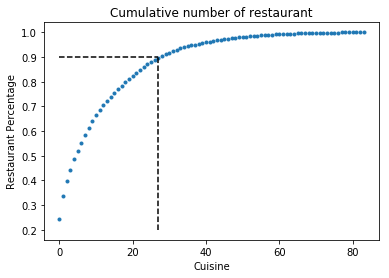

In [14]:
cuisine_counts = list(restaurant_attributes.cuisine_id.value_counts())
cum_cuisine = np.cumsum(cuisine_counts)/len(restaurant_attributes)
plt.plot(cum_cuisine,'.')
plt.plot([27,27],[0.2,0.9],'k--')
plt.plot([0,27],[0.9,0.9],'k--')
plt.title('Cumulative number of restaurant')
plt.xlabel('Cuisine')
plt.ylabel('Restaurant Percentage')

In [15]:
c_name, c_counts = np.unique(restaurant_attributes.cuisine_id, return_counts=True)
cuisine_list = c_name[c_counts>cuisine_counts[np.argwhere(cum_cuisine>0.9)[0][0]-1]]

In [16]:
cuisine_name = []
for i in range(len(restaurant_attributes)):
    if restaurant_attributes.cuisine_id.loc[i] in cuisine_list:
        cuisine_name.append(list(cuisine_names.cuisine_description.loc[cuisine_names.id ==restaurant_attributes.cuisine_id.loc[i]])[0])
    else: cuisine_name.append('Others')

In [17]:
restaurant_attributes['cuisine_name']= cuisine_name

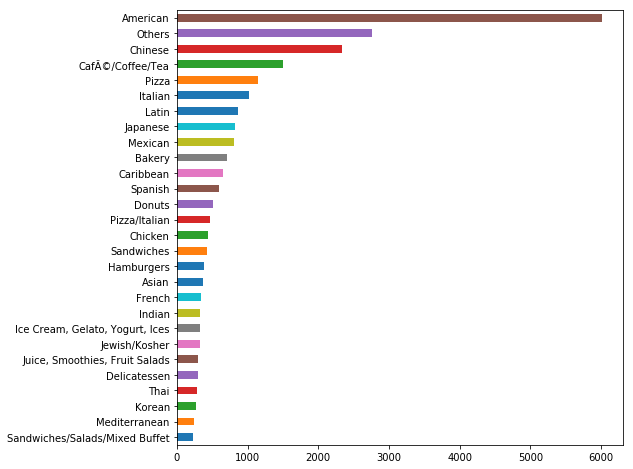

In [18]:
restaurant_attributes.cuisine_name.value_counts(ascending=True).plot(kind='barh', figsize = (8,8))

In [19]:
restaurant_attributes.head(5)

,restaurant_id,borough_id,building,street,zipcode,cuisine_id,cuisine_name
0,abb91d14a8c2e46a56ac3fb8d7b33d44,2,10,GRAND ARMY PLZ,11238,13,CafÃ©/Coffee/Tea
1,2acd3a862fee955f73cb5b12789eecbc,2,66,SOUTH 2 STREET,11249,47,Japanese
2,64db241ec98efba157bfcbdcbdbef664,3,2787,BROADWAY,10025,3,American
3,61e0212ce25de6f5dcb5a80aeb8c8705,3,1,E 118TH ST,10029,80,Others
4,345d4c0f7f0fb6cd70fda3f4ce89bec1,3,15,EAST 15 STREET,10003,47,Japanese


## 2. Violation Categories <a name="P32"></a>
According to the violation_names, there are 67 different types of violations. These violations can be further classified as critical and non-critical violations. I searched online to find more information about how the violations are graded and scored. From this [self-inspection worksheet](https://www1.nyc.gov/assets/doh/downloads/pdf/rii/self-inspection-worksheet.pdf), the violations can be further separated into 10 categories.


Category 1-7 are critical violations, and category 8-10 are non-critical violations.

- Category 1 (2 items): General Safety
- Category 2 (10 items): Food Temperature
- Category 3 (7 items): Food Source
- Category 4 (15 items): Food Protection
- Category 5 (9 items): Facility Design
- Category 6 (9 items): Personal Hygiene and other Food Protection
- Category 7 (1 item): Other Criticals
- Category 8 (3 items): Vermin/Garbage
- Category 9 (3 items): Food Source
- Category 10(10 items): Facility Maintenance

To visualize how the violation category related to the grade, I plotted the counts of violation categories associated with each grade, also normalized the counts to the total violation number of each grade.

In [20]:
# join the tables together to get the categories information
restaurant_violations = restaurant_violations.join(violation_names[['clause1','id']].set_index('id'), on='violation_id') 

In [21]:
violation_grid = np.arange(1,11)
grade_A = restaurant_violations.clause1.loc[restaurant_violations.grade=='A']
grade_B = restaurant_violations.clause1.loc[restaurant_violations.grade=='B'] 
grade_C = restaurant_violations.clause1.loc[restaurant_violations.grade=='C'] 

In [22]:
# Count the violation for each grade level
count_A = []
count_B = []
count_C = []
for i in violation_grid:
    count_A.append(sum(grade_A == i))
    count_B.append(sum(grade_B == i))
    count_C.append(sum(grade_C == i))

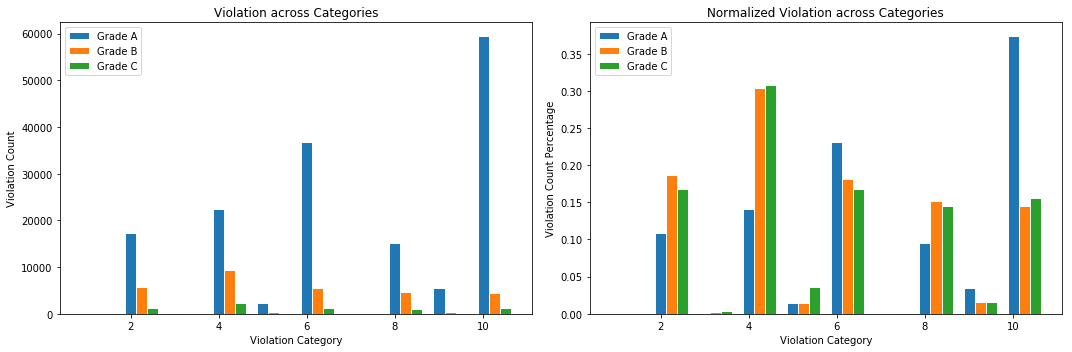

In [42]:
barWidth = 0.25

r1 = violation_grid
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

f,ax = plt.subplots(1,2,figsize = (15,5))
# Make the plot
ax[0].bar(r1, count_A,  width=barWidth, edgecolor='white', label='Grade A')
ax[0].bar(r2, count_B,  width=barWidth, edgecolor='white', label='Grade B')
ax[0].bar(r3, count_C,  width=barWidth, edgecolor='white', label='Grade C')
ax[0].legend()
ax[0].set_xlabel('Violation Category')
ax[0].set_ylabel('Violation Count')
ax[0].set_title('Violation across Categories')

ax[1].bar(r1, [i/sum(count_A) for i in count_A],  width=barWidth, edgecolor='white', label='Grade A')
ax[1].bar(r2, [i/sum(count_B) for i in count_B],  width=barWidth, edgecolor='white', label='Grade B')
ax[1].bar(r3, [i/sum(count_C) for i in count_C],  width=barWidth, edgecolor='white', label='Grade C')
ax[1].legend()
ax[1].set_xlabel('Violation Category')
ax[1].set_ylabel('Violation Count Percentage')
ax[1].set_title('Normalized Violation across Categories')
plt.tight_layout()

- The plot on the left shows that most of the violations lie in category 2, 4, 6, 8 and 10. Therefore, the inspector should pay more attention to these categories. 
- The raw count of grade A is much higher than the rest, which suggests there're much more grade A restaurants than grade B and C.
- The normalized plot on the right shows that lower graded restaurant (B and C) have a higher tendency of violating category 2, 4 and 8, while grade A restaurants tends to make more non-critical violation, such as category 10.

## 3. Chain restaurants <a name="P33"></a>
Around 6k of dupliates appear in the restaurant_name file, which indicates these restaurants have the same name and hence are chain restaurants. In here, I created a feature that identifies these chain restaurants.

Here's some examples of these chain restaurants.

In [24]:
restaurant_names.restaurant_name.value_counts().head(10)

DUNKIN' DONUTS                    407
SUBWAY                            368
STARBUCKS                         283
MCDONALD'S                        203
DUNKIN' DONUTS, BASKIN ROBBINS    111
KENNEDY FRIED CHICKEN              92
DOMINO'S                           84
BURGER KING                        83
POPEYES LOUISIANA KITCHEN          78
CROWN FRIED CHICKEN                72
Name: restaurant_name, dtype: int64

In [25]:
# get the list for names with duplicates
from toolz import frequencies, valfilter
chain_list = list(valfilter(lambda count: count > 1, frequencies(restaurant_names.restaurant_name)).keys())

In [26]:
r_names = []
chain = []
for i in range(len(restaurant_attributes)):
    tmp_name = list(restaurant_names.restaurant_name.loc[restaurant_names.id ==restaurant_attributes.restaurant_id.loc[i]])[0]
    r_names.append(tmp_name)
    if tmp_name in chain_list:
        chain.append(1)
    else: chain.append(0)

In [27]:
restaurant_attributes['restaurant_name'] = r_names
restaurant_attributes['chain'] = chain

# Creating Target <a name="P4"></a>

The goal of this analysis is  predict which restaurant is likely to degraded to C and provide the inspectors information regarding prioritizing the inspection process. Therefore, the target I'm looking for here is when the restaurant receives a grade C. <br>

However, using the violation information of the inspection resulting grade C doesn't provide any useful insights of predicting this event. Hence my strategy is to use the information of previous inspection to predict the probability of the restaurant falling to grade C in the next inspection.

### Summary of features:
- score: (continuous int)
- grade: (A/B/C, one-hot encoding)
- borough: (5 items, one-hot encoding)
- cuisine: (29 items, one-hot encoding)
- chain: chain restaurant(1) or not (0)
- critical: count of critial_vioation (continuous int)
- noncritical: count of non-critical violation (continous int)
- vio_cat_x: count of violation in each violation category (10 categories, continous int)
- duration: number of days the restaurant hasn't been inspected (continous int)


### Target: 
> 1, if the next inspection grade is C <br>
> 0, if the next inspection grade is A or B

In [28]:
# list of restaurants that had grade C
restaurant_list = np.unique(restaurant_violations.restaurant_id.loc[restaurant_violations.grade=='C'])

In [29]:
df = pd.DataFrame()
for name in restaurant_list:
    
    d_frame = restaurant_violations[restaurant_violations.restaurant_id==name]
    date_list = np.unique(d_frame.grade_date)
    data = pd.DataFrame()
    
    # calculate difference in time
    time_duration = []
    for i in range(len(date_list)):
        if i != len(date_list)-1:
            time_duration.append(int((date_list[i+1]-date_list[i])/ np.timedelta64(1, 'D')))
        else: time_duration.append(int((list(d_frame.record_date)[0]-date_list[i])/ np.timedelta64(1, 'D')))
    
    
    # construct data using dictionary
    for i in range(len(date_list)):
        date = date_list[i]
        sub_frame = d_frame.loc[d_frame.grade_date == date]
    
        # count each categories' violation number
        cat_list = []
        for j in violation_grid:
            cat_list.append(sum(sub_frame.clause1 == j))
    
        # create data entry using dictionary 
        data_dict = {'restaurant_id': list(sub_frame.restaurant_id)[0],
                 'grade_date': date,
                 'score': list(sub_frame.score)[0],
                 'grade': list(sub_frame.grade)[0],
                 'borough': list(restaurant_attributes.borough_id.loc[restaurant_attributes.restaurant_id == list(sub_frame.restaurant_id)[0]])[0],
                 'cuisine': list(restaurant_attributes.cuisine_name.loc[restaurant_attributes.restaurant_id == list(sub_frame.restaurant_id)[0]])[0],
                 'chain': list(restaurant_attributes.chain.loc[restaurant_attributes.restaurant_id == list(sub_frame.restaurant_id)[0]])[0],
                 'critical': sum(sub_frame.critical_flag =='Critical'),
                 'noncritical': sum(sub_frame.critical_flag == 'Not Critical'),
                 'vio_cat_1': cat_list[0],
                 'vio_cat_2': cat_list[1],
                 'vio_cat_3': cat_list[2],
                 'vio_cat_4': cat_list[3],
                 'vio_cat_5': cat_list[4],
                 'vio_cat_6': cat_list[5],
                 'vio_cat_7': cat_list[6],
                 'vio_cat_8': cat_list[7],
                 'vio_cat_9': cat_list[8],
                 'vio_cat_10': cat_list[9],
                 'duration': time_duration[i]
                }
        data = data.append(pd.DataFrame(data_dict, index=[i]),ignore_index= True)
        
    # get target variable by 
    target = []
    for item in range(len(data)-1):
        if data.grade.loc[item+1] == 'C':
            target.append(1)
        else: target.append(0)
        
    data = data[:-1]
    data['target'] = target
    
    df = df.append(data, ignore_index=True)

In [30]:
# replace the borough id with borough name
b_name = []
for i in range(len(df)):
    b_name.append(list(borough_names.borough_name.loc[borough_names.id == df.borough.loc[i]])[0] )
df.borough = b_name

# Modeling <a name="P5"></a>
## Random Forest Classifier <a name="P51"></a>

In [31]:
# get one hot encoding for categorical variables
cuisine_cat = pd.get_dummies(df.cuisine, prefix='Cuisine')
cuisine_cat = cuisine_cat.drop(columns = 'Cuisine_Others')
borough_cat = pd.get_dummies(df.borough, drop_first=True, prefix='Borough')
grade_cat = pd.get_dummies(df.grade, drop_first=True, prefix='Grade')

In [32]:
X = pd.concat([df.drop(['restaurant_id','grade_date','cuisine','target','borough','grade'], axis =1),cuisine_cat,borough_cat,grade_cat], axis=1)
y = df.target
# split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [33]:
rfc = RandomForestClassifier(n_estimators= 100);
rfc.fit(X_train, y_train);

In [34]:
print('Accuarcy of Random Forest: '+str(round(rfc.score(X_test, y_test),3)))
print('AUC of ROC of Randowm Forest: '+ str(round(roc_auc_score(y_test, rfc.predict_proba(X_test)[:,1]),3)))

Accuarcy of Random Forest: 0.784
AUC of ROC of Randowm Forest: 0.614


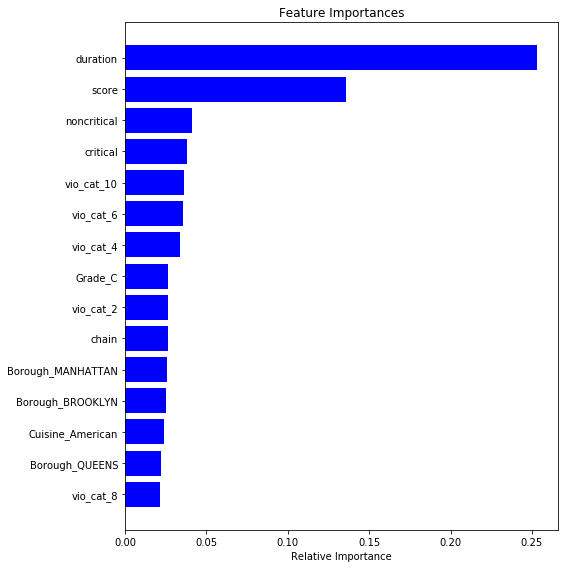

In [44]:
features = X.keys()
importances = rfc.feature_importances_
indices = np.argsort(importances)

f, ax = plt.subplots(1, figsize = (8,8))
plt.title('Feature Importances')
plt.barh(range(len(indices[-15:])), importances[indices[-15:]], color='b', align='center')
plt.yticks(range(len(indices[-15:])), [features[i] for i in indices[-15:]])
plt.xlabel('Relative Importance')
plt.tight_layout()
plt.show()

## Logistic Regression Classifier <a name="P52"></a>
Duration is in the unit of days, which is different than the rest of categorical variables. To properly compare the coefficients of features, a standard scaler is applied to features to normalize the values.

In [36]:
# normalize the feature values
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

lor = LogisticRegression();
lor.fit(X_train, y_train);

In [37]:
print('Accuarcy of Logistic Regression: '+str(round(lor.score(X_test, y_test),3)))
print('AUC of ROC of Logistic Regression: '+ str(round(roc_auc_score(y_test, lor.predict_proba(X_test)[:,1]),3)))

Accuarcy of Logistic Regression: 0.8
AUC of ROC of Logistic Regression: 0.625


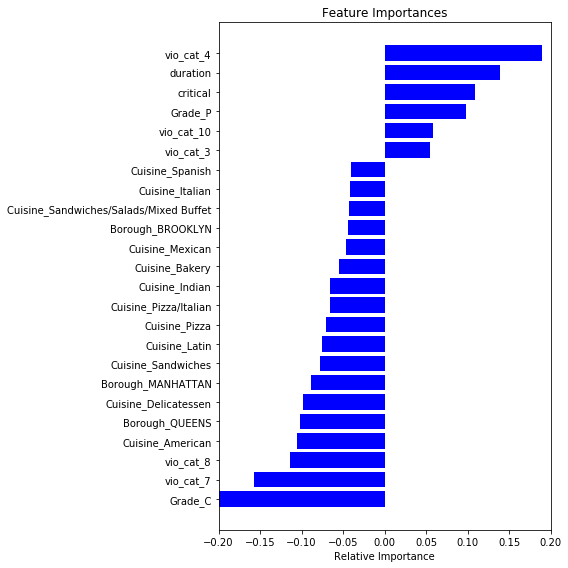

In [45]:
features = X.keys()
importances = lor.coef_[0]
indices = np.argsort(importances)
idx = abs(importances[indices])> np.median(abs(importances)) 

f, ax = plt.subplots(1, figsize = (8,8))
plt.title('Feature Importances')
plt.barh(range(len(indices[idx])), importances[indices][idx], color='b', align='center')
plt.yticks(range(len(indices[idx])), features[indices][idx])
plt.xlabel('Relative Importance')
plt.xlim([-0.2,0.2])
plt.tight_layout()
plt.show()

# Conclusion <a name="P6"></a>

To further investigate which features are important to the model, top 50% coefficients  from logistic regression was plotted below. The positive coefficients means when the feature value increases, the probability of target also increases, while features with negative coefficients decreased the target probability with increased value. <br>

Violation in category 4 is the strongest positive predictor of logistic regression model. Category 4 is about food protection and penalize on presence of rats, mice, roaches and flies in the restaurant. This result also suggests that failure in pest control may potentially develop into  much bigger problem. Duration since last inspection and number of critical violations in the previous inspection are also among the top 3 positive predictors. This result proves my previous speculation that infrequent visit from inspectors may facilitate the downgrade of the restaurant. <br>

The negative coefficients are interesting as well. A lot of cuisine types have negative coefficients, such as American, Delicatessen and Sandwiches. This result can be interpreted as the restaurants of these cuisines are more resistant to downgrade and are good at maintaining their environment and score. Grade_C has the most negative coefficient, which reflects the fact that when the restaurant reaches grade C, a lot of efforts were devoted to bring them back to better grade.
